In [1]:
import sys

sys.path.append("../imprint/research/berry/")
import berrylib.util as util

util.setup_nb()

In [2]:
import numpy as np
import scipy.stats
import scipy.spatial
import matplotlib.pyplot as plt
import berrylib.fast_inla as fast_inla

mu_mean = 0.1856
mu_sig2 = 0.05
sig2_alpha = 5.0
sig2_beta = 0.3
alpha = [24, 66, 40]
beta = [416.3, 331, 234]
lambdaj = scipy.stats.invgamma.mean(alpha, scale=beta)

fi = fast_inla.FastINLASurvival(
    lambdaj = lambdaj,
    n_arms=3,
    mu_0=mu_mean,
    mu_sig2=mu_sig2,
    sigma2_n=20,
    sigma2_bounds=[0.006401632420120484, 2.8421994410275007],
    sigma2_alpha=sig2_alpha,
    sigma2_beta=sig2_beta,
)

/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
data = np.array(
    [
        [
            [25.0, 490.89548468, 36.0],
            [39.0, 183.41089701, 39.0],
            [21.0, 107.54346258, 21.0],
        ]
    ]
)
data = np.tile(data, (3, 1, 1))
def test(data):
    sigma2_post, exceedance, theta_max, theta_sigma, _ = fi.numpy_inference(
        data, thresh_theta=np.repeat(np.log(1.0), 3)
    )
    interp = (exceedance[1] + exceedance[0]) * 0.5
    return exceedance[2] - interp

In [4]:
for i in range(1, 8):
    exp = data.copy()
    exp[1,:,0] += i
    exp[2,:,0] += i * 0.5
    err = test(exp)
    print(f'stepsize={i} err={err}')

stepsize=1 err=[ 0.00049239 -0.00065113 -0.0010742 ]
stepsize=2 err=[ 0.00125409 -0.00302736 -0.00489624]
stepsize=3 err=[ 0.00116635 -0.00755937 -0.01193999]
stepsize=4 err=[-0.00082454 -0.01439738 -0.02213172]
stepsize=5 err=[-0.00556371 -0.02342838 -0.03494603]
stepsize=6 err=[-0.01358831 -0.0343344  -0.04958173]
stepsize=7 err=[-0.02508081 -0.04666027 -0.06513422]


In [66]:
for i in range(1, 40, 4):
    exp = data.copy()
    exp[1,:,1] += i
    exp[2,:,1] += i * 0.5
    err = test(exp)
    print(f'stepsize={i} err={err}')

stepsize=1 err=[ 6.94856362e-06 -6.91507901e-06 -1.07058691e-05]
stepsize=5 err=[ 1.79435897e-04 -8.16559740e-05 -1.59140457e-04]
stepsize=9 err=[ 5.96972755e-04  2.33374259e-05 -1.72148750e-04]
stepsize=13 err=[0.00127227 0.00062297 0.00032659]
stepsize=17 err=[0.00221203 0.00198731 0.00165876]
stepsize=21 err=[0.0034176  0.00432991 0.00407643]
stepsize=25 err=[0.00488567 0.00780156 0.00775456]
stepsize=29 err=[0.00660899 0.01248902 0.01279017]
stepsize=33 err=[0.008577   0.01841807 0.01920707]
stepsize=37 err=[0.01077649 0.02555976 0.02696454]


In [5]:
n_events = np.arange(40).astype(np.float64)
total_time = np.arange(0, 600, 20).astype(np.float64)
NE, TT = np.meshgrid(n_events, total_time, indexing='ij')
d0_pairs = np.stack((NE, TT), axis=-1).reshape((-1, 2))
d0_pairs
grid = np.tile(d0_pairs[:, None], (1, 3, 1))

In [6]:
sigma2_post, exceedance, theta_max, theta_sigma, _ = fi.numpy_inference(
    grid, thresh_theta=np.repeat(np.log(1.0), 3)
)

/Users/tbent/Dropbox/active/confirm/research/inla_survival/../imprint/research/berry/berrylib/fast_inla.py:192: RuntimeWarning: overflow encountered in exp
  sigma2_post = np.exp(log_sigma2_post)
/Users/tbent/Dropbox/active/confirm/research/inla_survival/../imprint/research/berry/berrylib/fast_inla.py:193: RuntimeWarning: invalid value encountered in divide
  sigma2_post /= np.sum(sigma2_post * self.sigma2_rule.wts, axis=1)[:, None]


In [92]:
grid[400]

array([[ 13., 200.],
       [ 13., 200.],
       [ 13., 200.]])

In [93]:
exceedance[400]

array([0.71221166, 0.99998119, 0.999807  ])

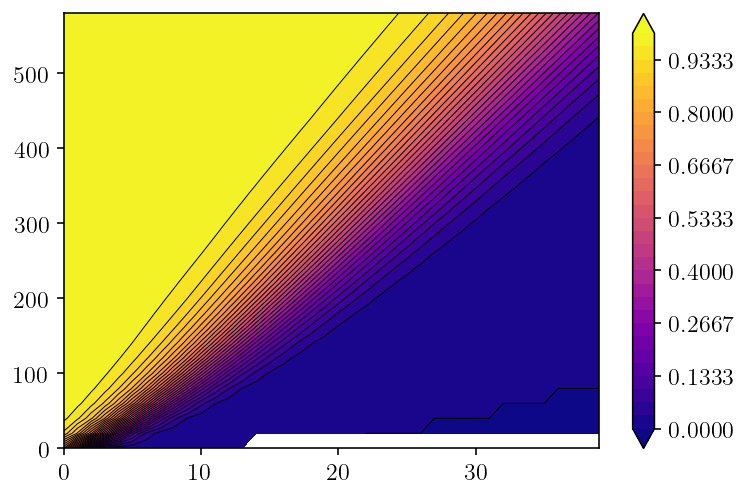

In [148]:
ex_grid = exceedance.reshape((*NE.shape, 3))
levels = None
levels = [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99, 0.999, 1.0]
levels = np.linspace(0, 1, 31)
cntf = plt.contourf(NE, TT, ex_grid[:,:,0], levels=levels, extend="both")
plt.contour(
    NE,
    TT,
    ex_grid[:,:,0],
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()

In [134]:
pt = np.tile(np.array([
    np.random.uniform(0, 40),
    np.random.uniform(0, 600)
])[None, None], (1, 3, 1))
_, pt_exceedance, _, _, _ = fi.numpy_inference(
    pt, thresh_theta=np.repeat(np.log(1.0), 3)
)
scale = 1.0 / np.array([1.0, 20.0])[None,:]
kdtree = scipy.spatial.KDTree(grid[:,0] * scale)
dist, idx = kdtree.query(pt[0,0] * scale, k=3)
pt_exceedance, exceedance[idx]

(array([[0.00215815, 0.65798003, 0.43901244]]),
 array([[[4.69084877e-03, 7.45035028e-01, 5.40636464e-01],
         [1.85767139e-03, 6.74891875e-01, 4.52179120e-01],
         [6.86717209e-04, 4.48813997e-01, 2.52094284e-01]]]))

In [135]:
dist, pt, grid[idx]

(array([[0.49393011, 0.5934694 , 0.90496463]]),
 array([[[ 19.44588051, 115.7499403 ],
         [ 19.44588051, 115.7499403 ],
         [ 19.44588051, 115.7499403 ]]]),
 array([[[[ 19., 120.],
          [ 19., 120.],
          [ 19., 120.]],
 
         [[ 20., 120.],
          [ 20., 120.],
          [ 20., 120.]],
 
         [[ 19., 100.],
          [ 19., 100.],
          [ 19., 100.]]]]))

In [139]:
pt_exceedance, exceedance[idx[0,0]], grid[idx[0,0]]

(array([[0.00215815, 0.65798003, 0.43901244]]),
 array([0.00469085, 0.74503503, 0.54063646]),
 array([[ 19., 120.],
        [ 19., 120.],
        [ 19., 120.]]))

In [177]:
tri = grid[idx[0], 0, :] * scale
T = tri[:2] - tri[2]
l1, l2 = np.linalg.solve(T, (pt[0,0] * scale[0] - tri[2]))
l3 = 1.0 - l1 - l2
l1, l2, l3

(0.34161650192763826, 0.4458805132434236, 0.21250298482893815)

In [182]:
interp_exceedance = np.sum(exceedance[idx[0]] * np.array([l1, l2, l3])[:, None], axis=0)

In [183]:
pt_exceedance, interp_exceedance 

(array([[0.00215815, 0.65798003, 0.43901244]]),
 array([0.0025767 , 0.65081171, 0.43987898]))

In [15]:
err = []
for i in range(1000):
    pt = np.tile(np.array([
        np.random.uniform(0, 40),
        np.random.uniform(0, 600)
    ])[None, None], (1, 3, 1))
    try:
        _, pt_exceedance, _, _, _ = fi.numpy_inference(
            pt, thresh_theta=np.repeat(np.log(1.0), 3)
        )
    except:
        continue


    scale = 1.0 / np.array([1.0, 20.0])[None,:]
    kdtree = scipy.spatial.KDTree(grid[:,0] * scale)
    dist, idx = kdtree.query(pt[0,0] * scale, k=3)

    tri = grid[idx[0], 0, :] * scale
    try:
        T = (tri[:2] - tri[2]).T
        l1, l2 = np.linalg.solve(T, (pt[0,0] * scale[0] - tri[2]))
    except:
        continue
    l3 = 1.0 - l1 - l2

    interp_exceedance = np.sum(exceedance[idx[0]] * np.array([l1, l2, l3])[:, None], axis=0)
    pt[0,0], tri / scale, exceedance[idx[0]], 
    err.append(pt_exceedance - interp_exceedance)
    # print('')
    # print('true exceedance', pt_exceedance)
    # print('interpolated exceedance', interp_exceedance)
err = np.array(err)

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_21184/1536716170.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(np.abs(err[:,0,0])), bins=np.linspace(-6, -1, 21))


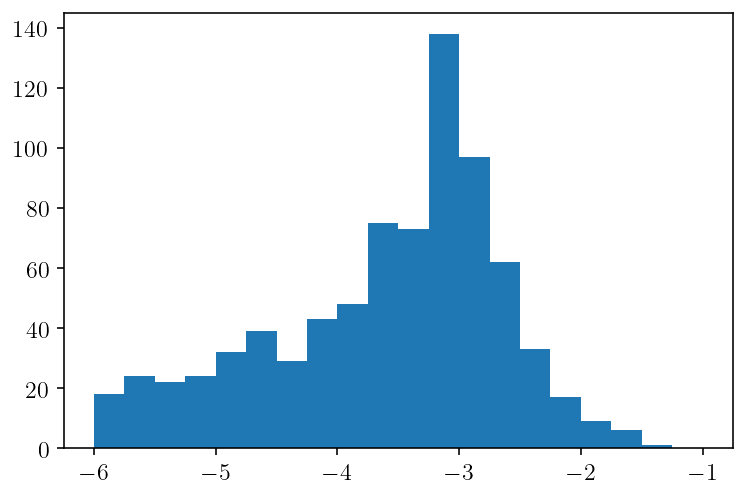

In [22]:
plt.hist(np.log10(np.abs(err[:,0,0])), bins=np.linspace(-6, -1, 21))
plt.show()

In [201]:
tri, pt[0,0] * scale[0]

(array([[15., 16.],
        [16., 16.],
        [15., 17.]]),
 array([15.47007893, 16.12011119]))

In [209]:
v = pt[0,0] * scale[0] - tri[2]
tri[:2] - tri[2], v

(array([[ 0., -1.],
        [ 1., -1.]]),
 array([ 0.47007893, -0.87988881]))

In [218]:
soln = np.linalg.inv((tri[:2] - tri[2]).T).dot(v)

In [219]:
soln

array([0.40980989, 0.47007893])

In [217]:
tri[:2] - tri[2]

array([[ 0., -1.],
       [ 1., -1.]])

In [202]:
l1, l2, l3

(-1.3499677398828105, -0.4700789260167184, 2.820046665899529)